# Assignment 6 - Pedestrian simulation

### SungJun(Tony), Baek. CSE5280

Video link for part1: https://youtu.be/J78E8HJ0a88
<br>
Video link for part2: https://youtu.be/TR2xZak6Um0


imported files:

In [279]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import symbols
from sympy.plotting import plot3d
from matplotlib import cm

### Map for part 1 from extra credit 1

In [280]:
import numpy as np
from vpython import *

canvas = canvas(title='Part 1 Scenario',
         length=500, width=500, height=500,
         center=vector(50,50,0), background=color.white)

#(x,y,z) -> (x,z,y)
floor = box(pos=vector(50,50,0),
       length=100, width=2, height=100)
floor.color = vec(0.689, 0.933, 1.000)

#Exit location at x = 100, y= 50
exit_floor = box(pos=vector(100,50,1.1),
       length=5, width=1, height=10,
       color=vec(0.455, 0.819, 0.466))

person_list = []
person_list.append(sphere(pos=vector(5,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(45,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(5,45,1), radius=1, color=color.red))

cylinder_list = []
cylinder_list.append(cylinder(pos=vector(90,50,0), axis=vector(0,0,10), radius=3, color=color.blue))
cylinder_list.append(cylinder(pos=vector(80,40,0), axis=vector(0,0,10), radius=3, color=color.blue))
cylinder_list.append(cylinder(pos=vector(70,30,0), axis=vector(0,0,10), radius=3, color=color.blue))
cylinder_list.append(cylinder(pos=vector(60,20,0), axis=vector(0,0,10), radius=3, color=color.blue))
cylinder_list.append(cylinder(pos=vector(50,10,0), axis=vector(0,0,10), radius=3, color=color.blue))

wall_list = []
for i in range(100):
    wall_list.append(cylinder(pos=vector(i,100,0), axis=vector(0,0,10), radius=1, color=color.green))
    wall_list.append(cylinder(pos=vector(100,i,0), axis=vector(0,0,10), radius=1, color=color.green))
    wall_list.append(cylinder(pos=vector(0,i,0), axis=vector(0,0,10), radius=1, color=color.green))
    wall_list.append(cylinder(pos=vector(i,0,0), axis=vector(0,0,10), radius=1, color=color.green))

<IPython.core.display.Javascript object>

### Calculate gradient field based on given coordinates

First, initialize and define function that calcuates the gradient

In [281]:
x = np.arange(0, 100, 1) #MapSize X
y = np.arange(0, 100, 1) #MapSize Y
X,Y = np.meshgrid(x,y)

#Returns z-based value from near 0 to near 1 ratio to the entire map
def map_gradient(endX, endY, xSize, ySize):
    norm_vector_Z = []
    for y in range(ySize):
        z_list =[]
        for x in range(xSize):
            distance = [(endX - x), (endY - y)]
            measure = math.sqrt(distance[0] ** 2 + distance[1] ** 2)
            normalized = (measure / (xSize))
            z_list.append(normalized)
        norm_vector_Z.append(z_list)
    return np.array(norm_vector_Z)

def cylinder_gradient(xPos, yPos, trueRadius, affectedRadius, xSize, ySize):
    if (trueRadius > affectedRadius):
        print("This will allow particle to go into the obstacles")
    z_matrix = []
    for y in range (ySize):
        row_matrix = []
        for x in range(xSize):
            #Calculate distance
            partial_distance = [(xPos - x), (yPos - y)]
            distance = math.sqrt(partial_distance[0] ** 2 + partial_distance[1] ** 2)
            #Normalized will have value between 0 ~ 1
            normalized = (xSize - distance) / xSize
            if(distance >= affectedRadius):
                row_matrix.append(0)
            elif(distance <= affectedRadius and distance >= trueRadius):
                gradient_increase = (normalized - 0.9)
                row_matrix.append(gradient_increase)
            else:
                row_matrix.append(normalized ** 3)
        z_matrix.append(row_matrix)
    return np.array(z_matrix)

def person_gradient(xPos, yPos, affective_area, xSize, ySize):
    #Particle must have certain value of repulsion
    z_matrix = []
    for y in range (ySize):
        row_matrix = []
        for x in range(xSize):
            #Calculate distance
            partial_distance = [(xPos - x), (yPos - y)]
            distance = math.sqrt(partial_distance[0] ** 2 + partial_distance[1] ** 2)
            normalized_by_map_size = (xSize - distance) / xSize #value ranged from 0 ~ radius
            #If that point is within an affective area
            if (distance < affective_area):
                normalized = 1 - (distance / affective_area)
                row_matrix.append(normalized ** 2)
            else:
                row_matrix.append(0)
        z_matrix.append(row_matrix)
    return np.array(z_matrix)

def wall_gradient(xPos, yPos, trueRadius, affectedRadius, xSize, ySize):
    if (trueRadius > affectedRadius):
        print("This will allow particle to go into the obstacles")
    z_matrix = []
    for y in range (ySize):
        row_matrix = []
        for x in range(xSize):
            #Calculate distance
            partial_distance = [(xPos - x), (yPos - y)]
            distance = math.sqrt(partial_distance[0] ** 2 + partial_distance[1] ** 2)
            #Normalized will have value between 0 ~ 1
            normalized = (xSize - distance) / xSize
            if(distance >= affectedRadius):
                row_matrix.append(0)
            elif(distance <= affectedRadius and distance >= trueRadius):
                gradient_increase = (normalized)
                row_matrix.append(gradient_increase)
            else:
                row_matrix.append(0)
        z_matrix.append(row_matrix)
    return np.array(z_matrix)

## Single frame gradient calculation

In [282]:
cylinder_radius = 3
affective_radius = 10

person_affective_radius = 3

wall_radius = 1
affective_wall_radius = 2
map_gradient_matrix = map_gradient(exit_floor.pos.x, exit_floor.pos.y, len(X), len(Y))

for cylinder in cylinder_list:
    #Total cost stays the same at this point
    map_gradient_matrix = np.add(map_gradient_matrix, cylinder_gradient(cylinder.pos.x, cylinder.pos.y,\
                                  cylinder_radius, affective_radius, len(X), len(Y)))
for wall in wall_list:
    #Total cost stays the same at this point
    map_gradient_matrix = np.add(map_gradient_matrix, wall_gradient(wall.pos.x, wall.pos.y,\
                                  wall_radius, affective_wall_radius, len(X), len(Y)))

#Change gradient by current paricles' position
#Need a separate field that only contains the map of particles gradient
def calculate_particles_gradient(gradient_map, person_list, raidus, lenX, lenY):
    for person in person_list:
        gradient_map = np.add(gradient_map, person_gradient(person.pos.x, person.pos.y,\
                                      raidus, lenX, lenY))
    return gradient_map

single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))
                              

# Initial map

### Red dots indicates particles, Blue dots(wide-cylinders-like gradient shpaes indicate cylinders)

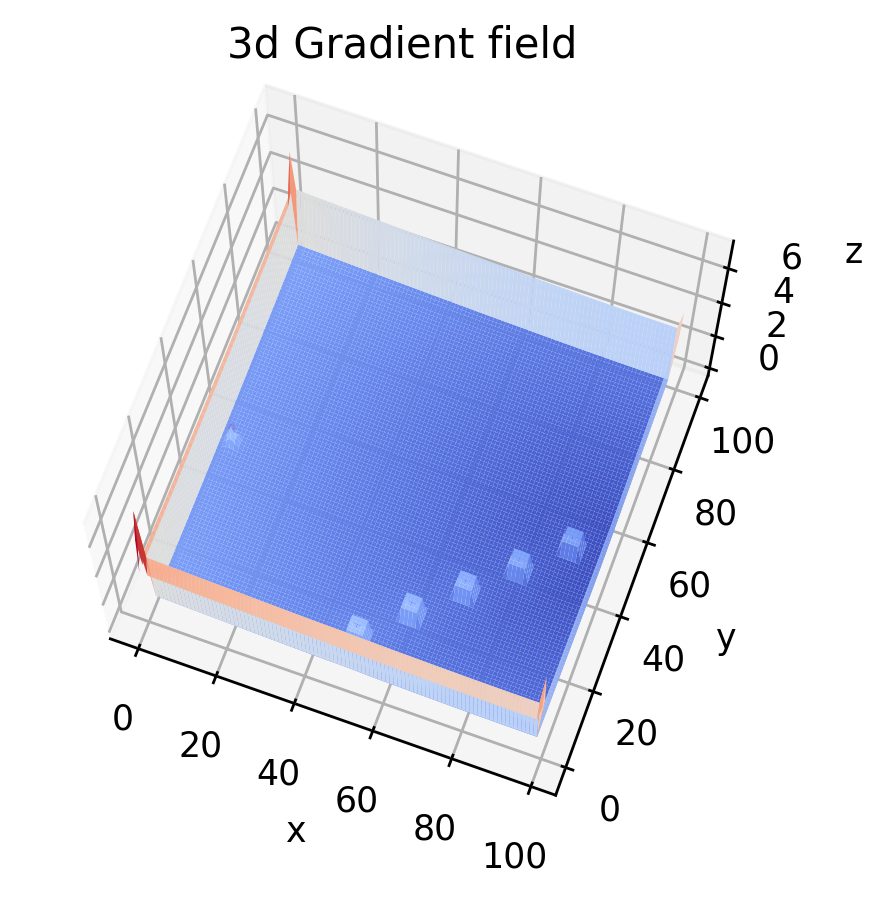

In [286]:
fig = plt.figure()
fig.set_dpi(250)
ax = fig.add_subplot(projection='3d')
ax.view_init(70, -70)
for cylinder in cylinder_list:
    ax.scatter3D(cylinder.pos.x, cylinder.pos.y, single_frame_cost[int(cylinder.pos.y)][int(cylinder.pos.x)],
                 c="blue", s=1)
for person in person_list:
    ax.scatter3D(person.pos.x, person.pos.y, single_frame_cost[int(person.pos.y)][int(person.pos.x)],
                 c="red", s=1)
ax.plot_surface(X, Y, single_frame_cost, cmap=cm.coolwarm, rstride = 1,  cstride =1)
ax.set_title('3d Gradient field')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#https://github.com/matplotlib/matplotlib/issues/5830/

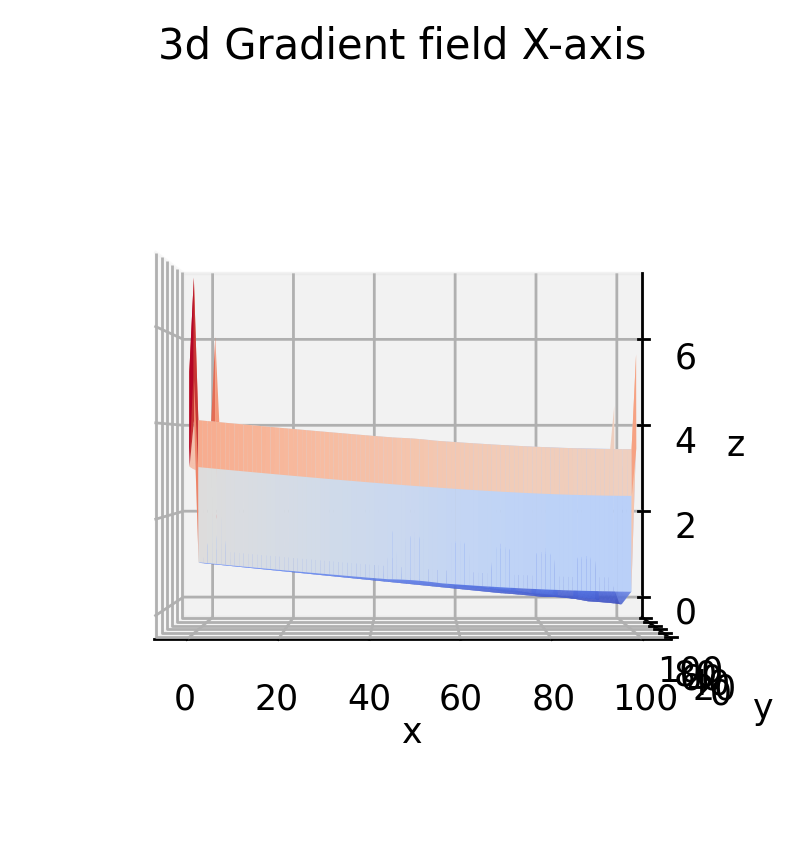

In [294]:
fig = plt.figure()
fig.set_dpi(250)
ax = fig.add_subplot(projection='3d')
ax.view_init(0, -90)
for cylinder in cylinder_list:
    ax.scatter3D(cylinder.pos.x, cylinder.pos.y, single_frame_cost[int(cylinder.pos.y)][int(cylinder.pos.x)],
                 c="blue", s=1)
for person in person_list:
    ax.scatter3D(person.pos.x, person.pos.y, single_frame_cost[int(person.pos.y)][int(person.pos.x)],
                 c="red", s=1)
ax.plot_surface(X, Y, single_frame_cost, cmap=cm.coolwarm, rstride = 1,  cstride =1)
ax.set_title('3d Gradient field X-axis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

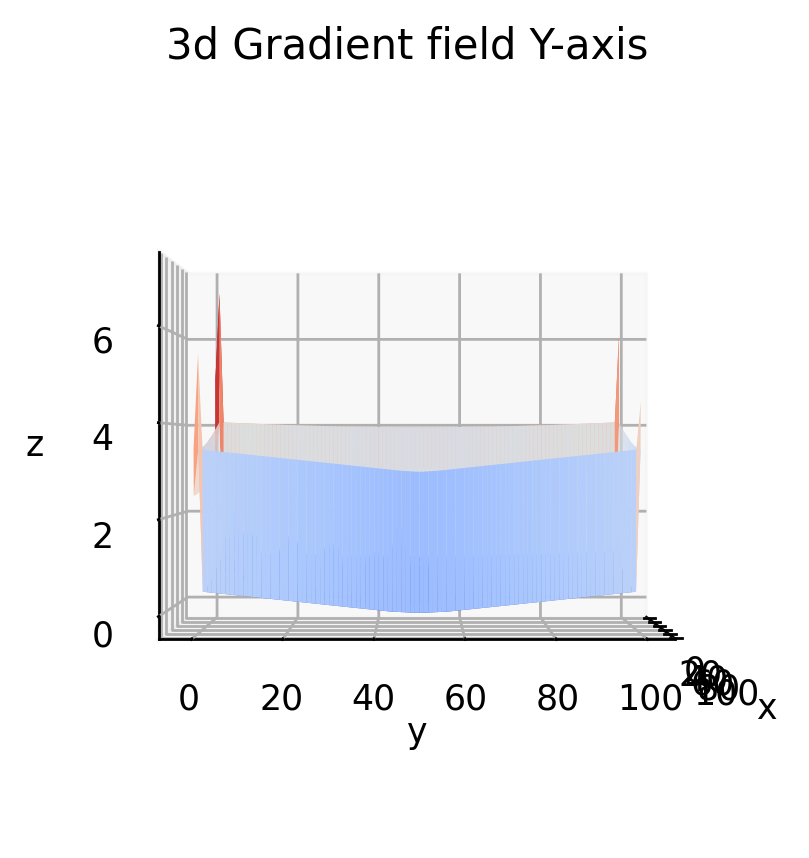

In [295]:
fig = plt.figure()
fig.set_dpi(250)
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 0)
for cylinder in cylinder_list:
    ax.scatter3D(cylinder.pos.x, cylinder.pos.y, single_frame_cost[int(cylinder.pos.y)][int(cylinder.pos.x)],
                 c="blue", s=1)
for person in person_list:
    ax.scatter3D(person.pos.x, person.pos.y, single_frame_cost[int(person.pos.y)][int(person.pos.x)],
                 c="red", s=1)
ax.plot_surface(X, Y, single_frame_cost, cmap=cm.coolwarm, rstride = 1,  cstride =1)
ax.set_title('3d Gradient field Y-axis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Find next smallest cost

Each point will find the smallest cost from its neigbors.

In [324]:
#Retuns next x, y points
def findSmallestCost(posX, posY, gradientMap):
    #Find 8 direction
    nextX = 0
    nextY = 0
    minimum_cost = float('inf')
    if (gradientMap[posY][posX - 1] <= minimum_cost):
        #print(gradientMap[posY][posX - 1], " : ", posX - 1, " - ", posY)
        minimum_cost = gradientMap[posY][posX - 1]
        nextX = -1
        nextY = 0
    if (gradientMap[posY][posX + 1] <= minimum_cost):
        #print(gradientMap[posY][posX + 1], " : ", posX + 1, " - ", posY)
        minimum_cost = gradientMap[posY][posX + 1]
        nextX = 1
        nextY = 0
    if (gradientMap[posY - 1][posX] <= minimum_cost):
        #print(gradientMap[posY - 1][posX], " : ", posX, " - ",  posY - 1)
        minimum_cost = gradientMap[posY - 1][posX]
        nextX = 0
        nextY = -1
    if (gradientMap[posY + 1][posX] <= minimum_cost):
        #print(gradientMap[posY + 1][posX], " : ", posX, " - ",  posY + 1)
        minimum_cost = gradientMap[posY + 1][posX]
        nextX = 0
        nextY = 1
    if (gradientMap[posY - 1][posX - 1] <= minimum_cost):
        #print(gradientMap[posY - 1][posX - 1], " : ", posX - 1, " - ",  posY - 1)
        minimum_cost = gradientMap[posY - 1][posX - 1]
        nextX = -1
        nextY = -1
    if (gradientMap[posY + 1][posX + 1] <= minimum_cost):
        #print(gradientMap[posY + 1][posX + 1], " : ", posX + 1, " - ",  posY + 1)
        minimum_cost = gradientMap[posY + 1][posX + 1]
        nextX = 1
        nextY = 1
    if (gradientMap[posY + 1][posX - 1] <= minimum_cost):
        #print(gradientMap[posY + 1][posX - 1], " : ", posX - 1, " - ",  posY + 1)
        minimum_cost = gradientMap[posY + 1][posX - 1]
        nextX = -1
        nextY = 1
    if (gradientMap[posY - 1][posX + 1] <= minimum_cost):
        #print(gradientMap[posY - 1][posX + 1], " : ", posX, " + ",  posY - 1)
        minimum_cost = gradientMap[posY - 1][posX + 1]
        nextX = 1
        nextY = -1
    return nextX, nextY

In [325]:
def findNextPoint(single_frame_cost, person_list):
    for person in person_list:
        #Update position
        nextX, nextY = findSmallestCost(int(person.pos.x), int(person.pos.y), single_frame_cost)
        person.pos = vector(person.pos.x + nextX, person.pos.y + nextY, 1)
        #Update gradient for social distancing / collision avoidance at this point
        
        #If that person hits the goal, skip the calculation
        #Goal area x = 97 ~ 100 y = 48 ~ 52
        tempX = person.pos.x + nextX
        tempY = person.pos.y + nextY
        if (tempX <= 100 and tempX >= 97 and tempY <= 52 and tempY >= 48):
            person_list.remove(person)
        
#Reset person location
person_list = []
person_list.append(sphere(pos=vector(5,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(45,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(5,45,1), radius=1, color=color.red))

single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))

index = 0
while(index < 100):
    if (len(person_list) == 0):
        break
    single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))
    findNextPoint(single_frame_cost, person_list)
    index += 1

# Animation part 2

## Map for part2 

In [320]:
import numpy as np
from vpython import *

canvas = canvas(title='Part 1 Scenario',
         length=500, width=500, height=500,
         center=vector(50,50,0), background=color.white)

#(x,y,z) -> (x,z,y)
floor = box(pos=vector(50,50,0),
       length=100, width=2, height=100)
floor.color = vec(0.689, 0.933, 1.000)

#Exit location at x = 100, y= 50
exit_floor = box(pos=vector(100,50,1.1),
       length=5, width=1, height=10,
       color=vec(0.455, 0.819, 0.466))

person_list = []
person_list.append(sphere(pos=vector(60,95,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(52,95,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(54,95,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(58,95,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(64,95,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(60,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(52,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(54,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(58,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(64,5,1), radius=1, color=color.red))

wall_list = []
for i in range(100):
    wall_list.append(cylinder(pos=vector(100,i,0), axis=vector(0,0,10), radius=1, color=color.green))
    wall_list.append(cylinder(pos=vector(50,i,0), axis=vector(0,0,10), radius=1, color=color.green))
    if (i >= 65 or i <= 35):
        wall_list.append(cylinder(pos=vector(75,i,0), axis=vector(0,0,10), radius=1, color=color.green))
    if (i >= 50 and i <= 75):
        wall_list.append(cylinder(pos=vector(i,0,0), axis=vector(0,0,10), radius=1, color=color.green))
    if (i >= 50 and i <= 75):
        wall_list.append(cylinder(pos=vector(i,100,0), axis=vector(0,0,10), radius=1, color=color.green))
    if (i >= 75):
        wall_list.append(cylinder(pos=vector(i,35,0), axis=vector(0,0,10), radius=1, color=color.green))
    if (i >= 75):
        wall_list.append(cylinder(pos=vector(i,65,0), axis=vector(0,0,10), radius=1, color=color.green))


<IPython.core.display.Javascript object>

In [321]:
cylinder_radius = 3
affective_radius = 10

person_affective_radius = 3

wall_radius = 1
affective_wall_radius = 2
map_gradient_matrix = map_gradient(exit_floor.pos.x, exit_floor.pos.y, len(X), len(Y))

for wall in wall_list:
    #Total cost stays the same at this point
    map_gradient_matrix = np.add(map_gradient_matrix, wall_gradient(wall.pos.x, wall.pos.y,\
                                  wall_radius, affective_wall_radius, len(X), len(Y)))

#Change gradient by current paricles' position
#Need a separate field that only contains the map of particles gradient
def calculate_particles_gradient(gradient_map, person_list, raidus, lenX, lenY):
    for person in person_list:
        gradient_map = np.add(gradient_map, person_gradient(person.pos.x, person.pos.y,\
                                      raidus, lenX, lenY))
    return gradient_map

single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))
              

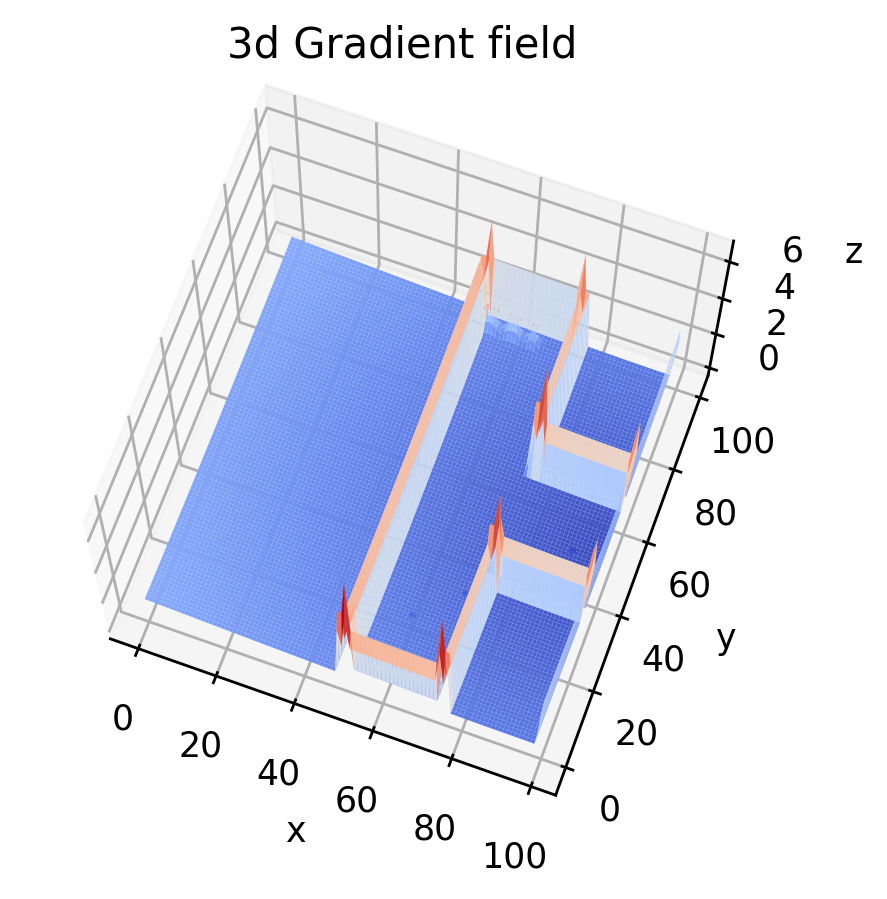

In [322]:
fig = plt.figure()
fig.set_dpi(250)
ax = fig.add_subplot(projection='3d')
ax.view_init(70, -70)
for cylinder in cylinder_list:
    ax.scatter3D(cylinder.pos.x, cylinder.pos.y, single_frame_cost[int(cylinder.pos.y)][int(cylinder.pos.x)],
                 c="blue", s=1)
for person in person_list:
    ax.scatter3D(person.pos.x, person.pos.y, single_frame_cost[int(person.pos.y)][int(person.pos.x)],
                 c="red", s=1)
ax.plot_surface(X, Y, single_frame_cost, cmap=cm.coolwarm, rstride = 1,  cstride =1)
ax.set_title('3d Gradient field')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [327]:
def findNextPoint(single_frame_cost, person_list):
    for person in person_list:
        #Update position
        nextX, nextY = findSmallestCost(int(person.pos.x), int(person.pos.y), single_frame_cost)
        person.pos = vector(person.pos.x + nextX, person.pos.y + nextY, 1)
        #Update gradient for social distancing / collision avoidance at this point
        
        #If that person hits the goal, skip the calculation
        #Goal area x = 97 ~ 100 y = 48 ~ 52
        tempX = person.pos.x + nextX
        tempY = person.pos.y + nextY
        if (tempX <= 100 and tempX >= 97 and tempY <= 52 and tempY >= 48):
            person_list.remove(person)
        
#Reset person location
person_list = []
person_list.append(sphere(pos=vector(5,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(45,5,1), radius=1, color=color.red))
person_list.append(sphere(pos=vector(5,45,1), radius=1, color=color.red))

single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))

index = 0
while(index < 100):
    if (len(person_list) == 0):
        break
    single_frame_cost = calculate_particles_gradient(map_gradient_matrix, person_list, person_affective_radius, len(X), len(Y))
    findNextPoint(single_frame_cost, person_list)
    index += 1